# url: https://qiita.com/kuroitu/items/57425380546f7b9ed91c

# 勾配ブースティング決定木ってなんぞや

## 対象者
今回は深層学習ではなく機械学習の一手法である勾配ブースティング決定木について覚書しています。
Kaggleなどで大活躍中(らしい)のXGBoostやLightGBMなどで用いられている機械学習手法について、最初からざっくり知りたい方はどうぞ覗いてください。

## 勾配ブースティング決定木とは
勾配ブースティング決定木(Gradient Boosting Decision Tree: GBDT)とは、「勾配降下法(Gradient)」と「アンサンブル学習(Boosting)」、「決定木(Decision Tree)」の3つの手法が組み合わされた機械学習の手法です。まずはそれぞれについて概説していきます。



## 勾配降下法
勾配降下法については過去記事(これとかこれ)で大体まとめてありますのでそちらも参照してください。
簡単に言うとある目的関数を最小化するための手法で、目的関数が連続関数である場合に用いることができる有効な手法です。深層学習ではその目的関数は誤差関数として与えられていますね。
アルゴリズムは

    1.現在地での目的関数の勾配(偏微分)を求める
    2.求めた勾配に応じて、あるルールに則り移動する
    3.目的関数の値の増減が閾値を下回れば学習終了、そうでなければ1へ戻る

のようになります。ここで言う「あるルール」というのがSGDやAdamに代表される学習則ですね。

url: https://qiita.com/kuroitu/items/36a58b37690d570dc618

url: https://qiita.com/kuroitu/items/ab5ad4ac716ae7a04891

## アンサンブル学習
アンサンブル学習(Ensemble Learning)は複数のモデルを同時に学習し、それらを相互に作用させることで大きな一つの学習モデルとしてモデルの精度を向上させる手法です。例えるなら「一人で問題に取り組むよりも複数人が知恵を持ち合って問題に取り組む方が早く正確である」という感じです。三人寄れば文殊の知恵というやつですね。
(ちなみに「烏合の衆」や「船頭多くして船山に登る」とも言うように、問題のサイズに対して適切なモデル数でないと過学習の原因になるなど余計な問題が発生します)
実際のアンサンブル学習のアルゴリズムは以下のようになります。

    1.複数のモデルを用意する
    2.各モデルを独立して学習させる
    3.学習後の複数のモデルそれぞれから、未知のデータに対する予測結果を取得する
    4.予測結果を多数決や平均などを用いて統合し、全体の予測結果として出力する

アンサンブル学習のメリットは、各モデルが弱学習器1であっても全体の予測精度が高精度になることにあります。簡単に数式で説明すると、二値分類で各モデルの誤判定率を一律に
と仮定すると、全体の誤判定率は

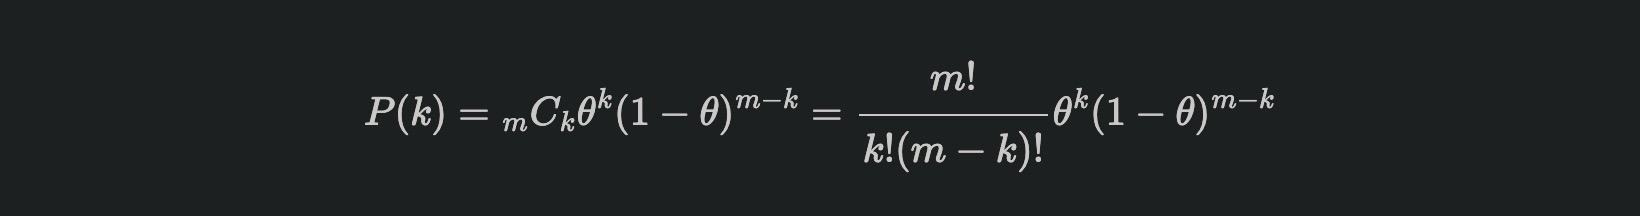

で計算されます。ここで

    m: モデルの数
    k: 誤判定を下したモデルの数

です。この式からわかるのは「mの値が大きいほどP(k)の値は小さくなる」ということです。これはかなり簡略というか、多くの仮定の元での議論なので直感的な理解の助けくらいにしかなりませんが、十分アンサンブル学習の威力を表していると言えるでしょう。

さて、ここまで「予測精度を高める」みたいなことを何度か言っていますが、そもそも予測精度を向上させるというのはどういうことでしょうか。ここで重要な用語として**バイアス(Bias)とバリアンス(Variance)**があります。
簡単に説明すると

    バイアス : 予測値と実際値との誤差の平均
    バリアンス : 日本語では「分散」ですね。データの散らばり具合を表します。今回は予測値の散らばり具を示します。

のようになります。

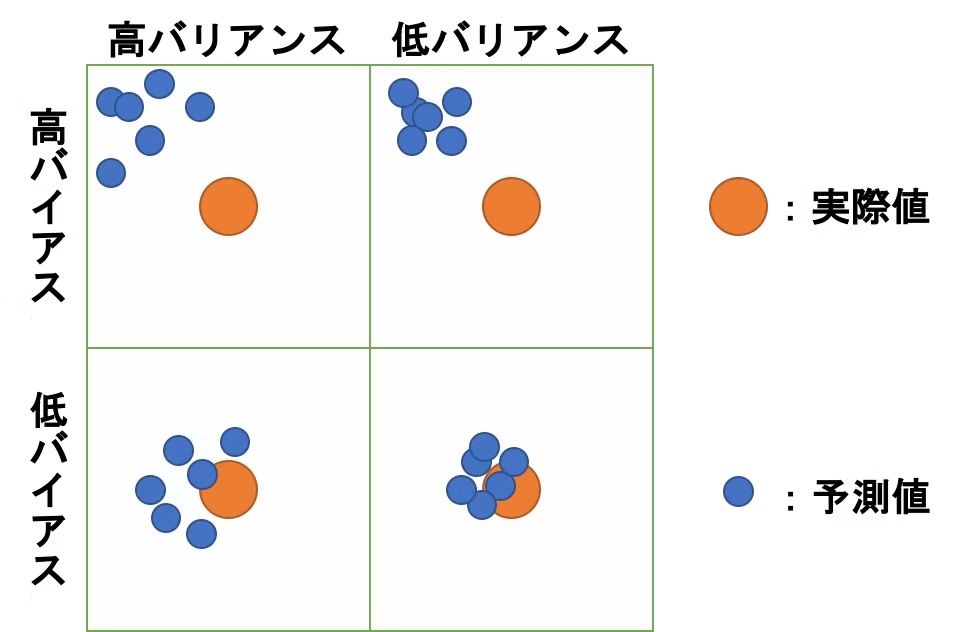

「予測精度を高める」というのは「低バイアス低バリアンスを目指す」ことと同義です。
しかしながら、実はバイアスとバリアンスはトレードオフの関係にあり、低バイアスを目指すと高バリアンスになってしまいます。

それの何が悪いのかというと、低バイアス高バリアンスの状態というのはいわゆる過学習の状態を表しています。訓練データにフィッティングしすぎて未知データに対してうまく予測できない状態となってしまっています。

ところで、これはモデルが一つの場合の話です。一つのモデルの表現能力で、全ての未知データにまでフィッティングしようと訓練させまくるとこのような結果が招かれることがある、という話です。なので複数のモデルで学習を行うことで、例えば各モデルの状態が低バイアス高バリアンス(つまり過学習)の状態にあっても、それらの多数決や平均をとることで結果的に低バイアス低バリアンスを実現できます。

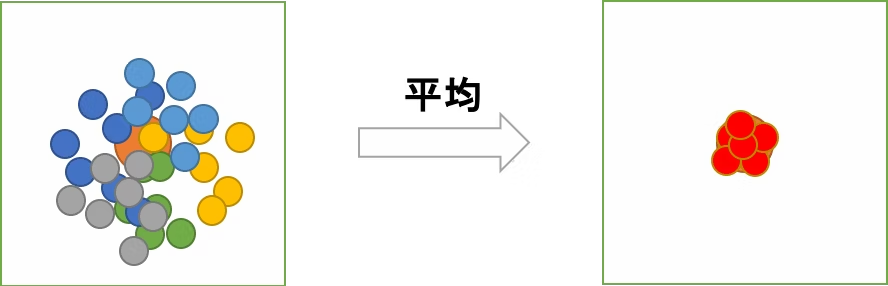

もちろん上図は相当都合の良い例ですので実際はこの通りとはいかないでしょうが、こんな感じで予測精度を向上させることができる、ということを理解できるでしょう。

ここまでアンサンブル学習の概要について説明しました。続いて代表手法の紹介に移ります。

## バギング
バギング(Bagging: Bootstrap Aggregating)は一般的にモデルの予測結果のバリアンスを低くする傾向があります。手法の概要としては、ブートストラップ手法を用いることでデータに多様性を持たせ、バリアンス低下につなげています。
ブートストラップ手法とは、母集団から得られた標本集団の平均値などの統計量から、母集団そのものの統計量を推定するための手法です。標本集団から重複を許してデータを抽出し、少し異なるデータセットを生成します。詳しくはこちらやこちらを参照してください。

## ブースティング
本記事の勾配ブースティング決定木にも登場するブースティングについてです。ブースティングはバギングとは異なりバイアスを低くする傾向があります。手法の概要としては「ある一つをベースモデルとして先に学習させ、ベースモデルの誤判定を加味して次のモデルを学習する」ということを繰り返し、最終的に全てのモデルを用いて全体の出力を構成します。これにより徐々に過学習的に訓練データにフィッティングしていき、また過学習していないモデルも含めて全体の意思決定を行うためバイアスが低下する傾向があります。ただし、もちろんモデルの数を増やしすぎると過学習を招きます。

## スタッキング
スタッキング(Stacking)は複雑な手法ですが、バイアスとバリアンス両方をうまく低下させることができる手法です。手法の概要としては、手法の名前の通り複数のモデルを積み重ねることで予測精度を向上させるものとなっています。より具体的には、まず第一層目の様々なモデルをバギングのように学習させ、次の層では第一層の出力結果からいくつか選択して利用するのですが、この時第二層では第一層のどのモデルの出力結果を用いれば良いかを学習します(ブースティングに近いですね)。これを繰り返していくことによって全体としてのモデルの精度を向上させることができます。

## 決定木
決定木とは木構造を用いて分類や回析を行う機械学習の手法の一つです。木構造と言ってもその辺に生えている木とは上下反対です。

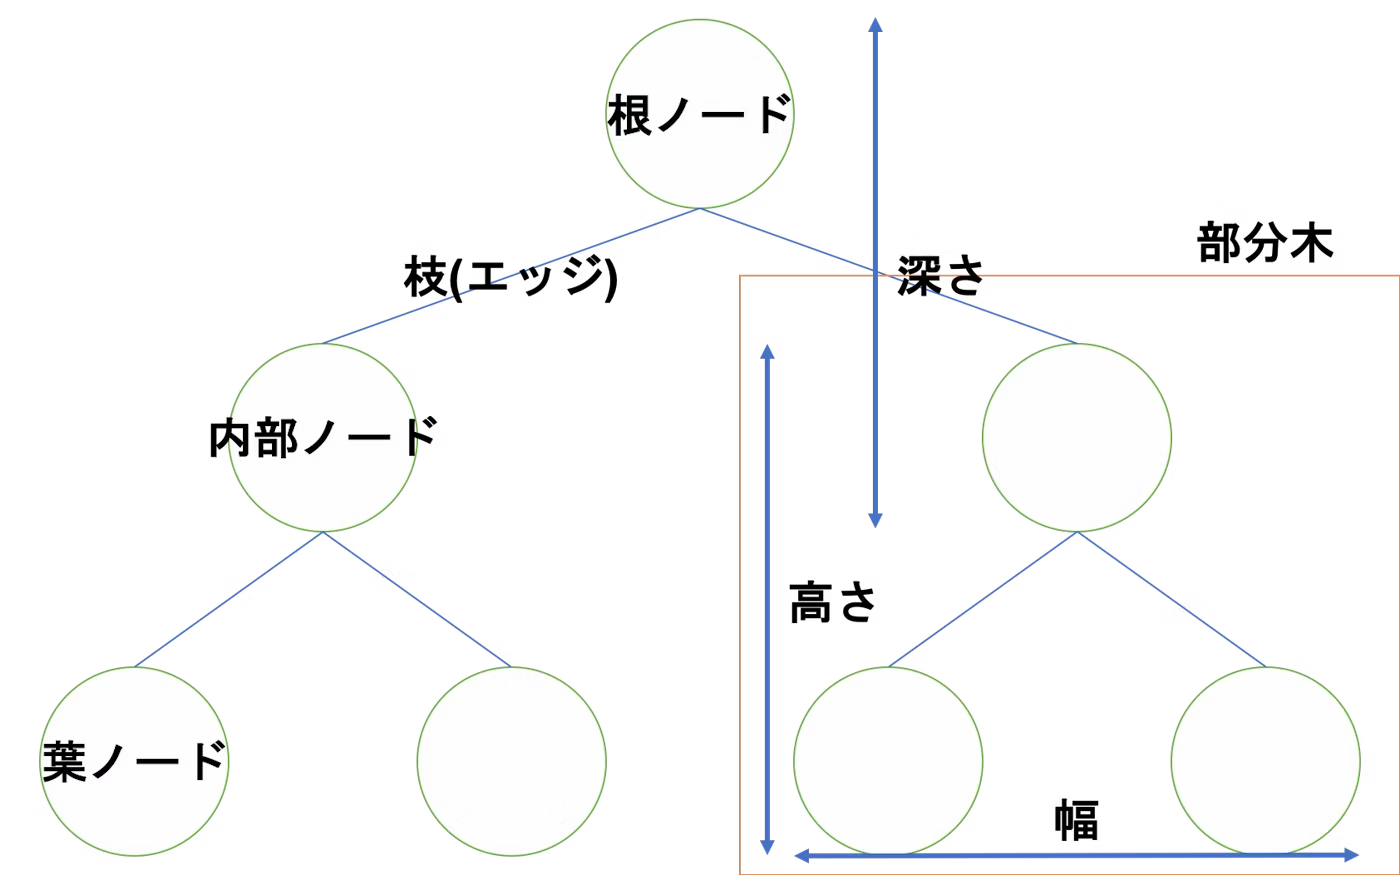

決定木はノードにデータを、エッジに条件分岐を設定するイメージです。

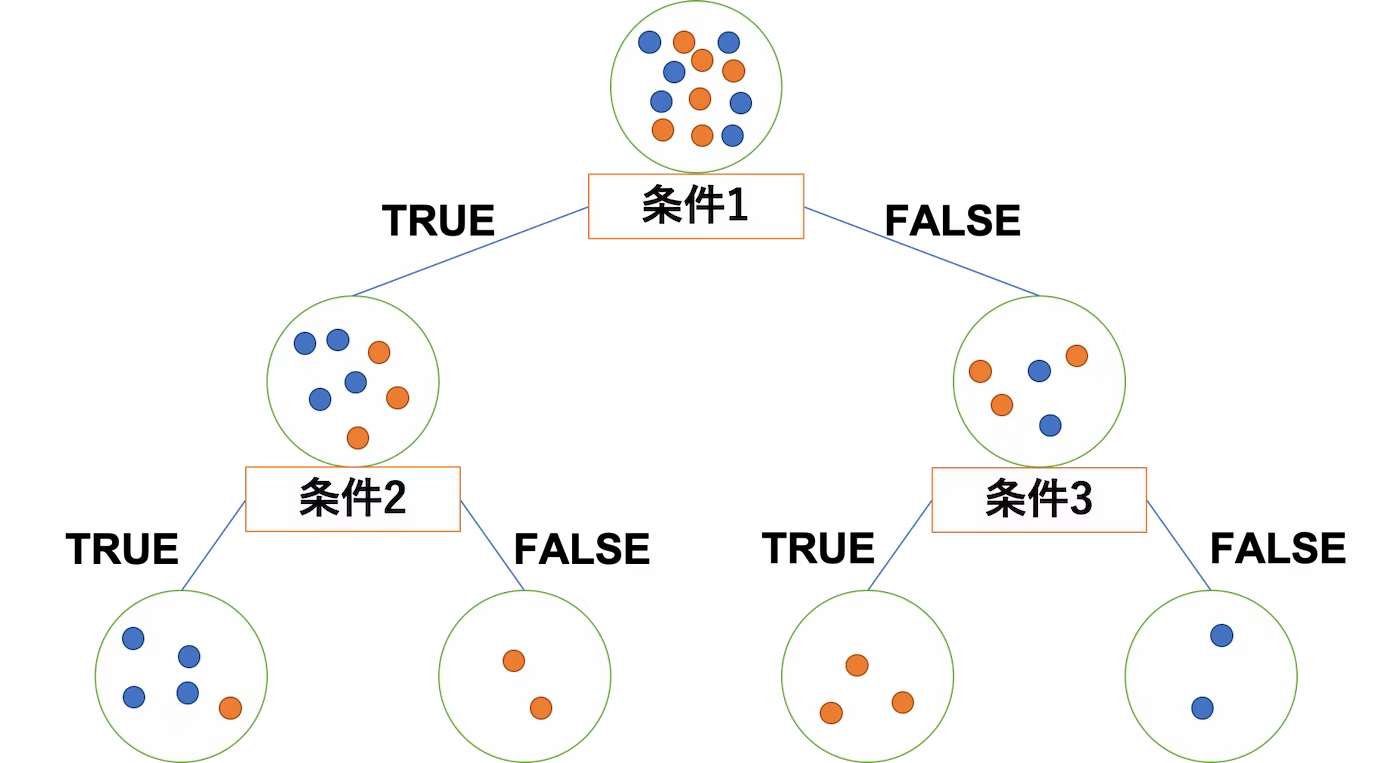

わかりやすいようにそれぞれのノード直下に条件分岐を書く欄を設けています。
こんな感じで条件分岐させてできるだけ正しくデータを分類するのが決定木です。
決定木の最大のメリットはどのようにしてアルゴリズムが分類したかを正確に説明することが可能な点です。昨今流行の深層学習などのニューラルネットワークでは分類結果は得られますが分類過程を知ることは事実上不可能であり、このブラックボックス問題をどうにかしようと様々な研究が行われているようです。

閑話休題...

決定木に関するより詳細な話題はこちらなどを参照してください。
決定木自体は先の図の通りですが、決定木というアルゴリズムではないことに注意してください。あくまで決定木は概念であって、これを構築するための様々なアルゴリズムが別にあります。

url: https://qiita.com/3000manJPY/items/ef7495960f472ec14377

## Level-wise tree growth
決定木の成長の仕方には2種類あります。まずはLevel-wiseから紹介します。
Level-wiseは、まあ簡単に言うと幅優先で成長する感じです。

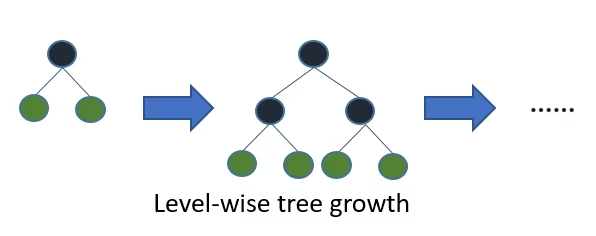

(図は公式ドキュメントより引用)

言語化しておくと「全ての葉ノードで根ノードからの深さが同じ」という感じですね。

## Leaf-wise tree growth
一方のLeaf-wiseは深さ優先で成長する感じです。

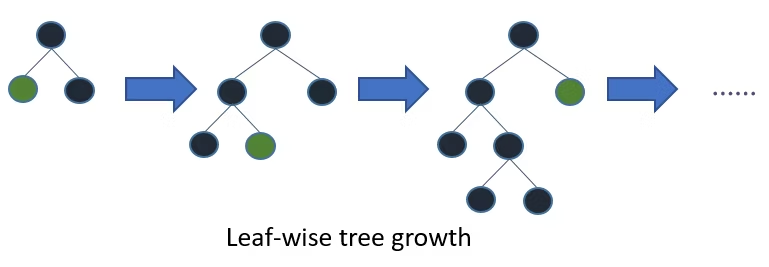

(図は公式ドキュメントより引用)
必要なノードからのみ次のノードを生成(このノードのことを子ノードと言います)する感じですね。Level-wiseよりも計算量が少なくなります。が、複雑になりがちです。そのためきちんと制御しないと過学習を起こしやすかったりもします。

## 勾配ブースティング決定木のアルゴリズム
ここまでで一応事前知識的な内容は終了です。上記で紹介した手法を複合したのが勾配ブースティング決定木(GBDT)となります。つまり勾配降下法とアンサンブル学習のブースティングを決定木に適用したのが勾配ブースティング決定木というわけです。
では実際のアルゴリズムについて見ていきます。
とりあえず手順は

    1.目的変数の平均を求め、初期予測値とする
    2.誤差を計算
    3.決定木を構築
    4.アンサンブル学習を用いて新たな予測値を算出
    5.十分な回数2~4を繰り返す
    6.最終的な予測値を出力する

という感じです。数式では

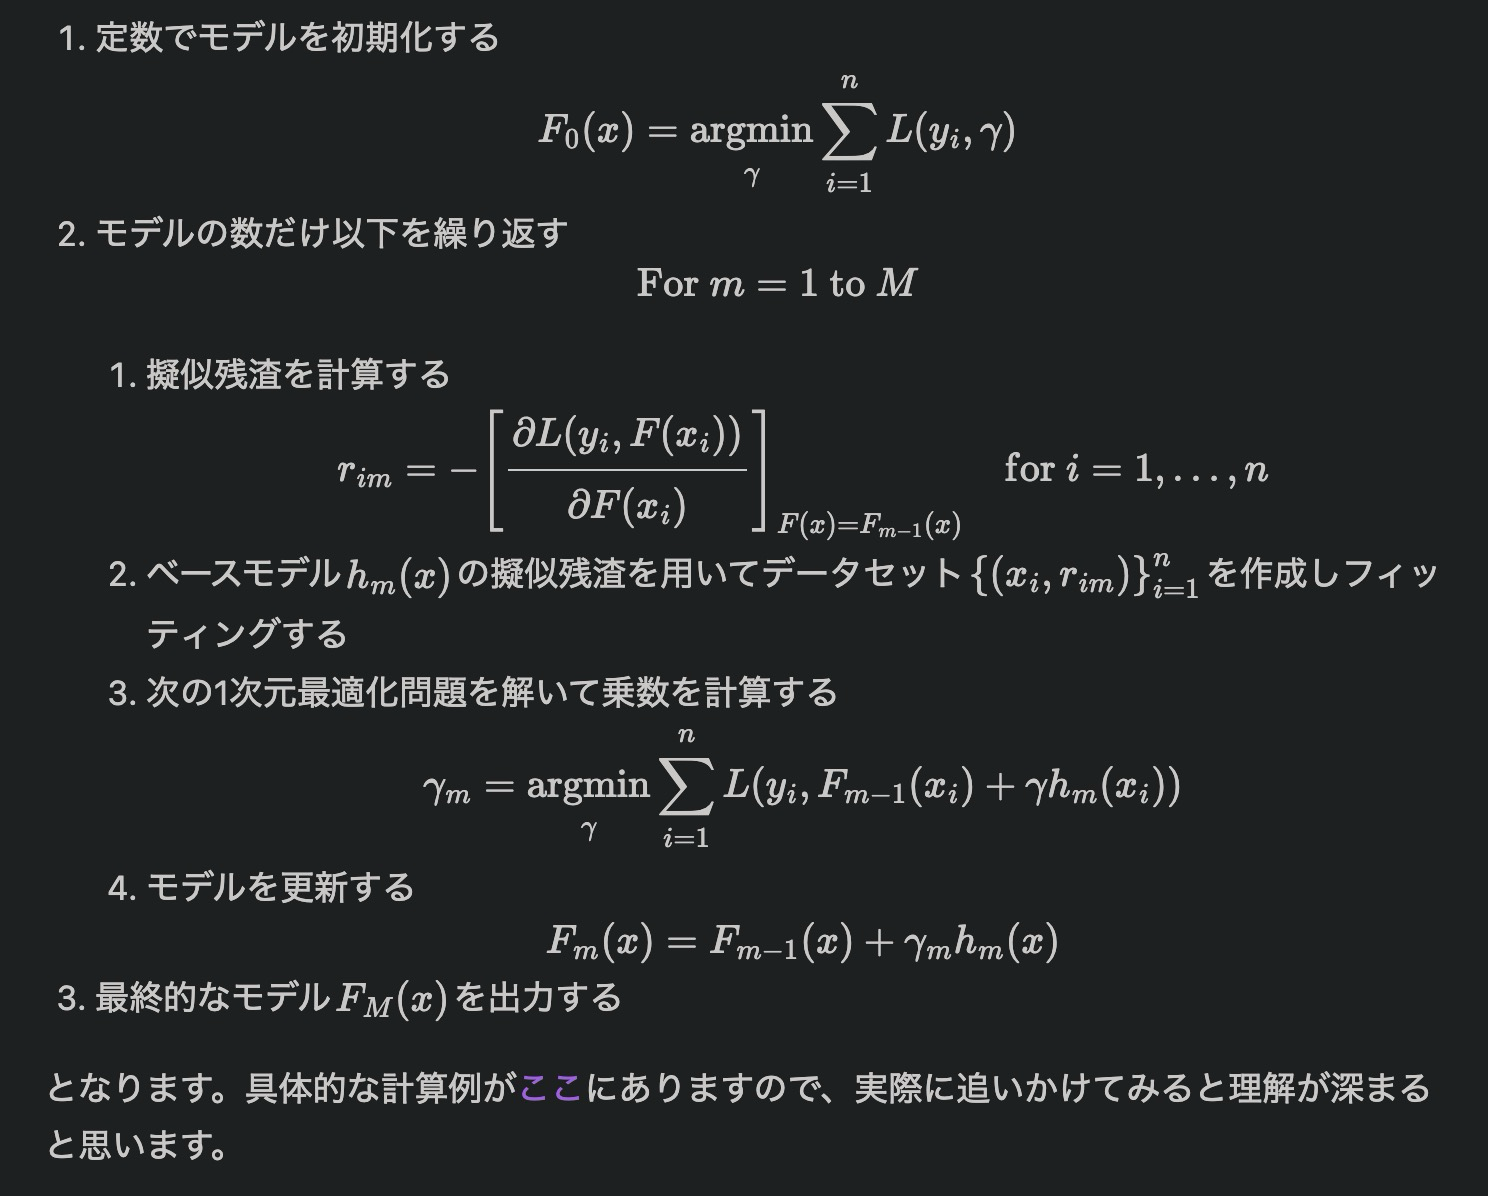

となります。具体的な計算例がここにありますので、実際に追いかけてみると理解が深まると思います。

url: https://www.acceluniverse.com/blog/developers/2019/12/gbdt.html

## 勾配ブースティング決定木の特徴
    教師あり学習の中でも特に強力な手法の一つ
    ブースティングを用いているため並列化できない
    パラメータに影響されやすいため過学習を起こしやすい
    スケール変換(標準化など)を行う必要がない
    外れ値などの影響を受けやすい
    決定木の深さは過学習抑制のため5以下に設定されることが多い

## XGBoost
さて、勾配ブースティング決定木を扱えるフレームワークを紹介していきます。まずはXGBoost(eXtreme Gradient Boosting)から紹介します。
後述のLightGBMが登場してから喰われつつあるらしいXGBoostですが、まだまだ現役で活躍している勾配ブースティング決定木のフレームワークになります。特徴としては

    高い規模拡張性
    効率よく理論的に正しい重み付き分位点を提案
    アンサンブル学習のための新しいスパース性認識アルゴリズム
    効率的なキャッシュ対応ブロック構造

とかなんとか論文には書いてました。いまいちわからん...気が向いたらちゃんと論文読むかな...
決定木構築アルゴリズムにHistogram-basedとPre-sortedの二つを採用しています。
ちなみにHistgram-basedの方は後から実装が追加されたみたいです。

    Pre-sorted Algorithm
    1.事前にソートされた特徴量から、全てのあり得る分割点を数え上げる手法
    2.最適分割点は求まるが時間・空間効率が悪い
    Histogram-based Algorithm
    1.連続値特徴量を離散値変換して、それを元にヒストグラムを構築する手法
    2.一般に最適分割点は求まらないが時間・空間効率が良い

詳しくはここなどを参照してください。
XGBoostの方は決定木の成長の仕方がLevel Wiseなのかな？いろいろ調べましたが明記されていないので微妙なところ...ただ、パラメータ次第でLeaf-wiseにできる、みたいな記述はありましたのでおそらくLevel-wiseなのでしょう。

url: https://arxiv.org/pdf/1603.02754.pdf

url: https://threecourse.hatenablog.com/entry/2019/10/23/000519

## LightGBM
続いてLightGBM(Light Gradient Boosting Machine)です。こちらは2016年にリリースされ、その精度と圧倒的高速処理から人気を博しているフレームワークになります。
その特徴は

    時間・空間計算量削減
    疎なデータのヒストグラム構築高速化
    ヒストグラムの分割点の求め方を最適解ではなく次善解に変更し高速化
    並列化可能

などなど。とりあえず高精度なまま高速化に成功したって感じでいいんですかね〜
決定木構築アルゴリズムは、LightGBMではHistogram-basedのみ採用されています。
すごくざっくり言うとLightGBMは勾配ブースティング決定木にGOSSとEFBを取り入れたもの、という認識でいいようです。
GOSSとEFBは勾配ブースティング決定木における以下の問題点を改善するための新しい手法です。

    データセット削減のためのダウンサンプリングにおいて、データの分布が変わってしまうから精度が悪くなってしまう
    Histgram-basedアルゴリズムでは疎なデータセットに対しても特徴量削減ができない

それぞれの手法について簡単にまとめていきます。



## GOSS
GOSS(Gradient-based One-Side Sampling)は

訓練データのサイズを削減するためによく用いられるデータのダウンサンプリング2という手法において、元のデータセットの分布を復元できる周波数以下でダウンサンプリングすると分布が変わってしまい、結果として精度が悪くなる

という問題を回避するための手法です。
周波数というのは言葉の綾です。サンプリング周波数云々の話は信号処理に該当するので、その辺りをググるとわかると思います(信号処理の分野のサンプリング定理とか)。

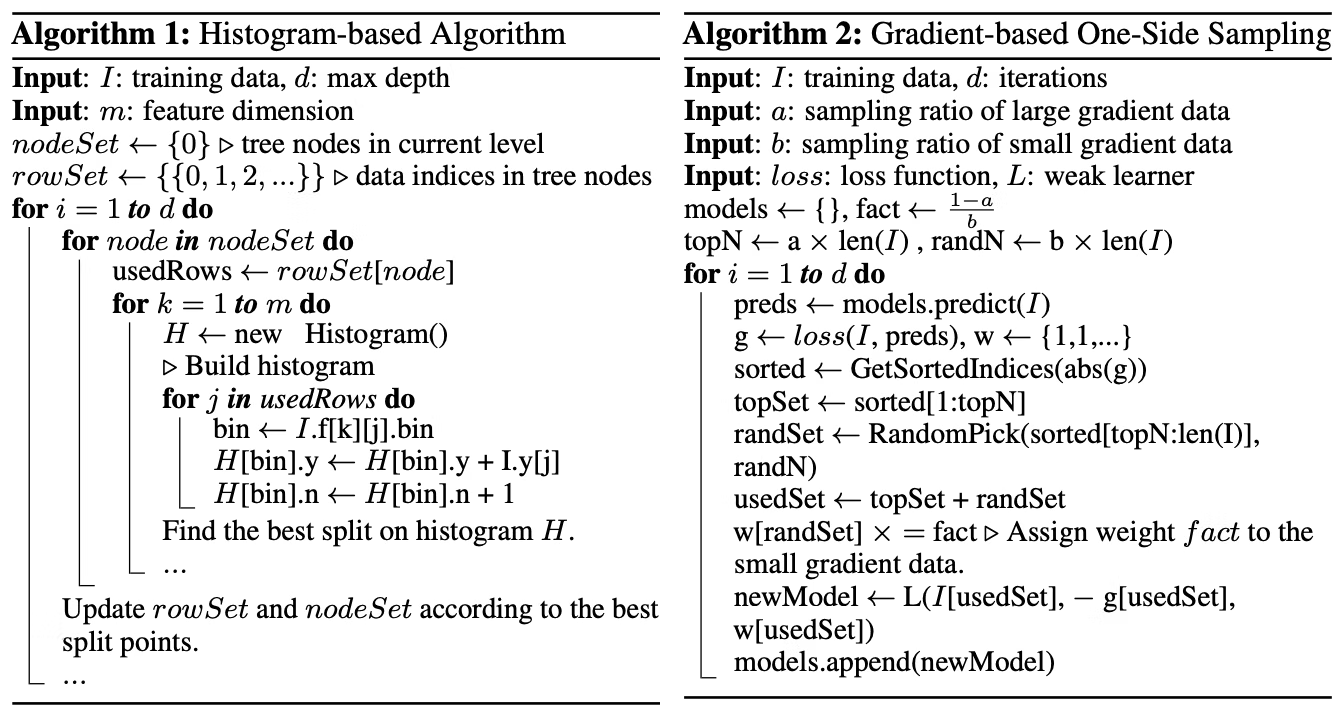

## GOSSアルゴリズムの概要
勾配ブースティング決定木ではAdaBoostでのサンプリング手法をそのまま使用することができませんが、その代わり勾配が同じような役割を果たせることに注目します。勾配が小さいなら誤差が小さくすでに十分学習済みである、ということですね。ここで簡単に思いつくアイデアとして「勾配の小さなデータは破棄する」というのが挙がると思いますが、これではデータの分布が変わってしまうという問題があります。
そこでGOSSでは「勾配の大きなデータはそのまま、小さいデータはランダムサンプリングする」という方法を採ります。データを勾配の絶対値でソートし、上位 a * 100%
のデータをキープ、残りのデータのうちb * 100%
のデータをランダムサンプリングします。その後小さい勾配(b * 100%
のデータ)にはデータのゲイン**3を計算する際に (1-a) / bを乗算することで、訓練不足のデータに対してデータの分布を損なうことなしに注目することができます。
詳しい理論解析は原論文見てください

url: https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf

### EFB
EFB(Exclusive Feature Bundling)は

現実世界を対象とするデータセットは通常疎であり、無視できる特徴量を無視することで計算コストを削減することができるが、Histgram-basedアルゴリズムではそのアルゴリズムの特性上特徴量がゼロである/ないにかかわらず特徴量を保持しているbinにアクセスする必要があるため前述のような特徴量削減ができない

という問題に対する新しい改善策です。

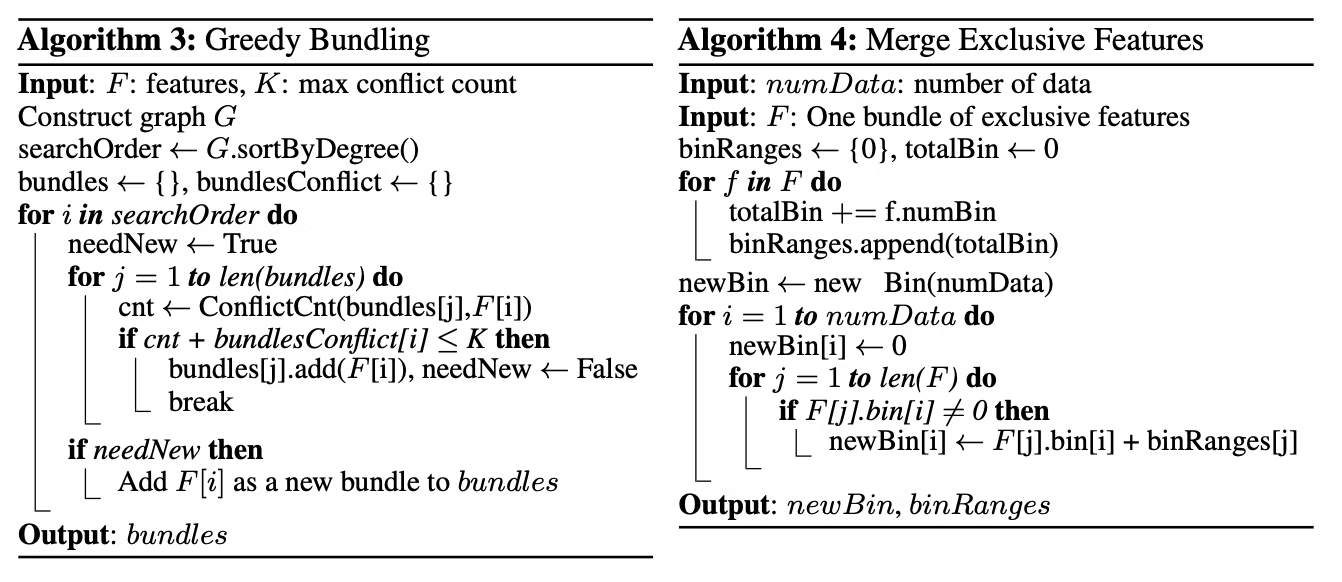

## EFBアルゴリズムの概要
高次元のデータは通常非常に疎となっており、このことから特徴量削減の可能性があることがわかります。また、高次元データの疎性は排他的であることが多く、同時に複数の特徴量が非ゼロな値を取ることは少ないです。そのような特性から安全に排他的特徴量を単一の特徴量へと束ねることができ、この操作をExclusive Feature Bundleと呼ぶことにします。このようなアルゴリズムを構築するためには次の2点の問題がありました。

どの特徴量を束ねるかをどう決定するか
どのようにバンドルを構築するか
1点目について、この問題はグラフ彩色問題4と同等であると見做せるのですが、これはNP困難と呼ばれる問題に分類されます。ちなみにNP困難などのクラス分けは簡単に言うと

P: 多項式時間で解くことができるアルゴリズムが示されている問題が属するクラス
NP: 多項式時間で解の存在を証明できるアルゴリズムが示されている問題が属するクラス
NP-hard: (必ずしも決定的ではない)解法アルゴリズムを多項式時間で任意のNP問題へと変換できる問題が属するクラス
NP-complete: NPとNP-hard両方に属する問題が属するクラス
という感じにクラス分けされています。
2点目について、最適なバンドル戦略を多項式時間で見つけることができないことは示されているので、次善戦略を見つけるため

グラフ彩色問題における各頂点と特徴を対応させ、それが排他的でない場合は2特徴量ごとにエッジを追加する

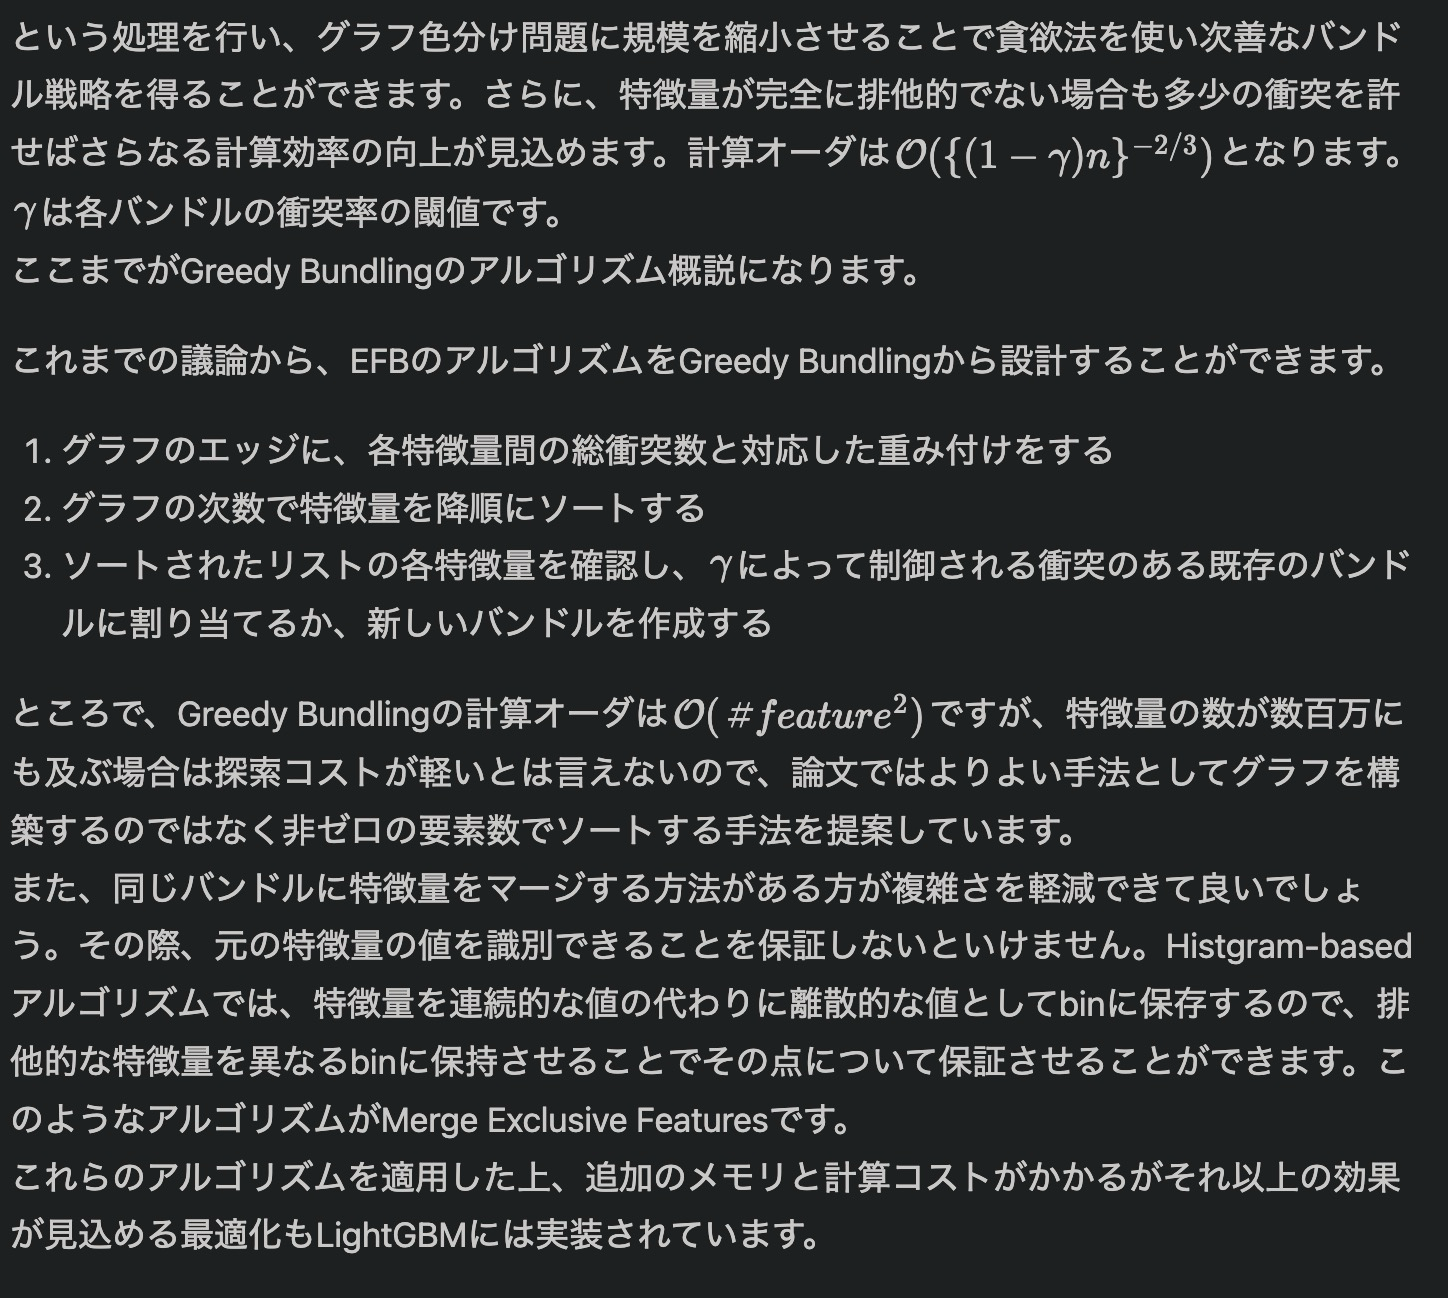

## Catboost
LightGBMで力尽きたのでいずれ書きます...

## 試してみる
では、XGBoostとLightGBMの2つで実際にMNISTデータセットの分類で実験してみましょう。

ちなみにLightGBMのインストールはなぜかpipインストールで行うと上手くいきませんでした。gccでのインストールも試しましたがうまくいかず...が、brewでやるとすんなり。なんなのでしょう...
もし困った人がいればgithubのリポジトリを見てください。

例の如く実行環境はjupyter notebookです。test.ipynbというファイルで実験します。

1つ目のセルにはpipインストールを用意しています。すでに必要なパッケージがインストール済みなら不要です。

url: https://github.com/microsoft/LightGBM/blob/master/docs/Installation-Guide.rst

In [1]:
# %pip install lightgbm
# %pip install xgboost
# %pip install tensorflow
# %pip install sklearn

2つ目のセルはMNISTデータセットインストール時に謎のエラーが出たので追加しました。

url: https://github.com/tensorflow/tensorflow/issues/33285

In [2]:
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [3]:
import time
import xgboost as xgb
import lightgbm as lgb
import numpy as np
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# MNISTデータセットの事前準備
(x_train, t_train), (x_test, t_test) = mnist.load_data()

# 学習データと検証データに分割
split_ratio = 0.2
x_train, x_validation, t_train, t_validation = train_test_split(x_train, t_train, test_size=split_ratio)

# 平滑化
x_train = x_train.reshape(-1, 784)
x_validation = x_validation.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# 正規化
x_train = x_train.astype(float) / 255
x_validation = x_validation.astype(float) / 255
x_test = x_test.astype(float) / 255

# データを設定
xgb_train_data = xgb.DMatrix(x_train, label=t_train)
xgb_eval_data = xgb.DMatrix(x_validation, label=t_validation)
xgb_test_data = xgb.DMatrix(x_test, label=t_test)
lgb_train_data = lgb.Dataset(x_train, label=t_train)
lgb_eval_data = lgb.Dataset(x_validation, label=t_validation, reference=lgb_train_data)

4つ目のセルにはXGBoostの実験コード本体が記述してあります。

In [4]:
# XGBoostモデル構築
start = time.time()
xgb_params = {"objective": "multi:softmax",
              "num_class": 10,
              "eval_metric": "mlogloss"}
evals = [(xgb_train_data, "train"), (xgb_eval_data, "eval")]
gbm = xgb.train(xgb_params, xgb_train_data,
                num_boost_round=100,
                early_stopping_rounds=10,
                evals=evals)
preds = gbm.predict(xgb_test_data)
print("accuracy score: {}".format(accuracy_score(t_test, preds)))
print("elapsed time: {}".format(time.time() - start))

[0]	train-mlogloss:1.36035	eval-mlogloss:1.38833
[1]	train-mlogloss:1.02213	eval-mlogloss:1.06257
[2]	train-mlogloss:0.80214	eval-mlogloss:0.85110
[3]	train-mlogloss:0.64950	eval-mlogloss:0.70485
[4]	train-mlogloss:0.53458	eval-mlogloss:0.59385
[5]	train-mlogloss:0.44551	eval-mlogloss:0.50777
[6]	train-mlogloss:0.37658	eval-mlogloss:0.44238
[7]	train-mlogloss:0.32122	eval-mlogloss:0.39023
[8]	train-mlogloss:0.27700	eval-mlogloss:0.34884
[9]	train-mlogloss:0.24143	eval-mlogloss:0.31518
[10]	train-mlogloss:0.21184	eval-mlogloss:0.28701
[11]	train-mlogloss:0.18791	eval-mlogloss:0.26516
[12]	train-mlogloss:0.16605	eval-mlogloss:0.24410
[13]	train-mlogloss:0.14884	eval-mlogloss:0.22852
[14]	train-mlogloss:0.13382	eval-mlogloss:0.21425
[15]	train-mlogloss:0.12005	eval-mlogloss:0.20101
[16]	train-mlogloss:0.10887	eval-mlogloss:0.19068
[17]	train-mlogloss:0.09966	eval-mlogloss:0.18220
[18]	train-mlogloss:0.09093	eval-mlogloss:0.17427
[19]	train-mlogloss:0.08275	eval-mlogloss:0.16659
[20]	train

5つ目にはLightGBMの実験コード本体が記述してあります。

In [5]:
# LightGBMモデル構築
start = time.time()
lgb_params = {"task": "train",
             "boosting_type": "gbdt",
             "objective": "multiclass",
             "num_class": 10}
gbm = lgb.train(lgb_params, lgb_train_data,
                valid_sets=lgb_eval_data,
                num_boost_round=100
                # early_stopping_rounds=10
                )
preds = gbm.predict(x_test)
y_pred = []
for x in preds:
    y_pred.append(np.argmax(x))

print("accuracy score: {}".format(accuracy_score(t_test, y_pred)))
print("elapsed time: {}".format(time.time() - start))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.542639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 107038
[LightGBM] [Info] Number of data points in the train set: 48000, number of used features: 622
[LightGBM] [Info] Start training from score -2.315164
[LightGBM] [Info] Start training from score -2.182582
[LightGBM] [Info] Start training from score -2.310323
[LightGBM] [Info] Start training from score -2.286056
[LightGBM] [Info] Start training from score -2.327049
[LightGBM] [Info] Start training from score -2.405633
[LightGBM] [Info] Start training from score -2.324064
[LightGBM] [Info] Start training from score -2.265771
[LightGBM] [Info] Start training from score -2.325129
[LightGBM] [Info] Start training from score -2.298427
accuracy score: 0.9765
elapsed time: 146.53337621688843


精度はそれほど変わりませんが速度が段違いですね。
注意して欲しいのが 「LightGBMが常に優れている」ということではない ということです。MNISTデータセットではたまたま同じような精度でより高速に動作しただけであって、実際にはXGBoostの方がいいこともありますし、LightGBMの方がいいこともあります。要は使い分けが大切ということです。この辺りの話は勾配降下法と通じるモノがありますね。

## 参考

    弱学習器とは
    【入門】アンサンブル学習の代表的な２つの手法とアルゴリズム
    機械学習上級者は皆使ってる？！アンサンブル学習の仕組みと3つの種類について解説します
    [入門]初心者の初心者による初心者のための決定木分析
    GBDTの仕組みと手順を図と具体例で直感的に理解する
    GREEDY FUNCTION APPROXIMATION: A GRADIENT BOOSTING MACHINE
    Gradient Boosting
    XGBoost論文を丁寧に解説する(1)
    XGBoost論文を丁寧に解説する(2): ShrinkageとSubsampling
    XGBoostの概要
    XGBoost原論文
    LightGBM原論文
    LightGBM: a highly efficient gradient boosting decision tree
    LightGBM公式ドキュメント
    機械学習における勾配ブースティングのアルゴリズム「XGBoost」「LightGBM」「CatBoost」の違い
    またまた、LightGBMのインストールでエラーが出た

## 実装の参考

    XGboostとは？理論とPythonとRでの実践方法！
    勾配ブースティング手法をPythonで実装して比較していく！
    LightGBM 徹底入門 – LightGBMの使い方や仕組み、XGBoostとの違いについて
    手を動かして GBDT を理解してみる
    機械学習コンペで人気のLightGBMをPythonで使ってみた

## おわりに
今まで深層学習とかにばっかり注力してましたが、他にもいろいろな機械学習手法があるんだな〜と思いました。やっぱAI関連の話は難しくて勉強しがいのある分野ですね〜全く理論を理解できませんが泣笑
精進します...

1.単独では予測精度が低いモデルのこと。明確な定義はないみたいですが、決定木やシンプルなニューラルネットワークなどは弱学習器とみなして良いとのことです。 ↩

2.一般にはサンプリング周波数を元のサンプリング周波数よりも下げてデータの個数を減らす処理のことを言います。ここでは単純にデータセットを間引く感じですね。 ↩

3.日本語で「利得」とかって訳されます。文脈によってニュアンスがかなり異なります。共通するのは「ある式などにおける支配的な指標」みたいな感じですかね〜ここではデータに課す重みを指しています。 ↩

4.これなどを参照してください。 ↩

url: https://ja.wikipedia.org/wiki/%E3%82%B0%E3%83%A9%E3%83%95%E5%BD%A9%E8%89%B2